In [462]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, mean_squared_error

In [463]:
df = pd.read_excel('../../Passes_df.xlsx')
df.head()

,x_passer,y_passer,x_recipient,y_recipient,distance_sideline,distance_goal,distance_opponent,speed_passer,opponents_closer_to_goal,distance_receiver_sideline,distance_receiver_goal,distance_receiver_opponent,opponents_closer_to_goal_receiver,speed_receiver,bypassed_opponents,angle,opponents_in_path,nearest_defender_pass_line,distance_pass,completed
0,0.41,-0.39,-11.02,1.70,33.777011,52.127550,9.208914,1.21,10,32.467011,63.578823,12.561676,11,0.67,0,169.637818,0,2.358155,11.619509,1
1,-2.18,21.42,9.33,18.21,12.747011,58.759399,7.627273,0.61,11,15.957011,46.886783,5.297141,9,1.08,1,-15.583144,1,0.028496,11.949234,1
2,10.89,28.86,-0.95,20.79,5.307011,50.668496,3.939975,1.50,11,13.377011,57.384545,12.844150,11,1.37,0,-145.722133,0,3.434173,14.328660,1
3,25.18,29.32,11.20,29.33,4.847011,40.100101,1.167090,1.07,10,4.837011,50.684527,13.070275,11,0.86,0,179.959016,1,1.139821,13.980004,1
4,13.67,22.75,22.51,29.13,11.417011,45.034826,3.316022,5.68,8,5.037011,41.834472,5.276381,7,4.58,4,35.818717,1,1.562856,10.901835,1


In [464]:
# Extract feature and target arrays
X, y = df.drop('completed', axis=1), df[['completed']]

In [465]:
params = {'base_score': 0.5,
 'booster': 'gbtree',
 'gamma': 1,
 'learning_rate': 0.1,
 'n_estimators': 200,
 'reg_alpha': 0.5,
 'reg_lambda': 5}

In [466]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, train_size=4500)

In [467]:
xgb_model = xgb.XGBClassifier(**params, objective="binary:logistic", random_state = 42, scale_pos_weight = 0.4)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [468]:
xgb_model.feature_importances_

array([0.04280084, 0.03339154, 0.04732361, 0.03700138, 0.04102534,
       0.04496901, 0.04529438, 0.03577049, 0.04847686, 0.03624799,
       0.04047684, 0.05675195, 0.0771106 , 0.09603211, 0.08341411,
       0.03344895, 0.10149685, 0.034644  , 0.06432316], dtype=float32)

In [469]:
fi = pd.DataFrame(data = {'feature' : X_train.columns, 'importance' : xgb_model.feature_importances_})
fi.sort_values('importance')

,feature,importance
1,y_passer,0.033392
15,angle,0.033449
17,nearest_defender_pass_line,0.034644
7,speed_passer,0.035770
9,distance_receiver_sideline,0.036248
3,y_recipient,0.037001
10,distance_receiver_goal,0.040477
4,distance_sideline,0.041025
0,x_passer,0.042801
5,distance_goal,0.044969


In [470]:
print('CF trainig')
y_pred = xgb_model.predict(X_train)
print(confusion_matrix(y_train, y_pred))

CF trainig
[[ 468   88]
 [  65 3879]]


In [471]:
print('CF test')
y_pred = xgb_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

CF test
[[ 24  42]
 [ 25 481]]


In [472]:
y_pred = xgb_model.predict_proba(X_train)
roc_auc_score(y_train,y_pred[:,1])

0.9901808776102852

In [473]:
y_pred = xgb_model.predict_proba(X_test)
roc_auc_score(y_test,y_pred[:,1])

0.8632770391663673

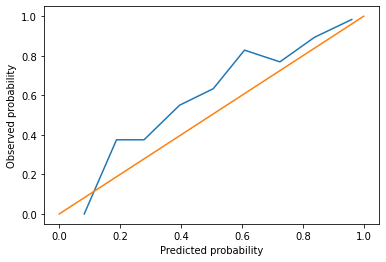

In [474]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
pos_frac, mean_val = calibration_curve(y_test,y_pred[:,1],n_bins=9)
plt.plot(mean_val, pos_frac)
plt.plot([0,1],[0,1])
plt.xlabel('Predicted probability')
plt.ylabel('Observed probability')
plt.show()

In [645]:
df_comp = pd.read_excel('astonvilla_comparison.xlsx')
X_comp = df_comp.drop(columns = ['period','gameClock','team.name','player.jersey_nb','pass.recipient.jersey_nb','coord_all_team','coord_all_adversary','completed','Unnamed: 0','player.id','pass.recipient.id'])
df_comp['xPass'] = xgb_model.predict_proba(X_comp)[:,1]
df_comp['xPass'] *=1.05
df_comp = df_comp.drop(columns=['Unnamed: 0'])
df_comp = df_comp.sort_values(['period','gameClock'])
df_comp_2 = pd.concat([df_comp[df_comp['period']==1], df_comp[(df_comp['gameClock']<=15*60) & (df_comp['period']==2)]])
# df_comp_2 = df_comp_2[df_comp_2['gameClock']<=15*60]
df_comp_2['pass_nb'] = 1
df_grouped = df_comp_2[['player.id','xPass','completed','pass_nb']].groupby('player.id').sum()
df_grouped['xPass_mean'] = df_grouped['xPass']/df_grouped['pass_nb']
df_grouped['perf'] = df_grouped['completed']-df_grouped['xPass']
df_grouped

,xPass,completed,pass_nb,xPass_mean,perf
player.id,,,,,
4637,20.852638,20,21,0.992983,-0.852638
4649,13.822540,15,16,0.863909,1.177460
5078,38.779606,37,42,0.923324,-1.779606
10163,23.205868,25,27,0.859477,1.794132
10252,29.758772,30,36,0.826633,0.241228
15555,11.955266,14,17,0.703251,2.044734
15570,8.898928,10,15,0.593262,1.101072
19416,19.588770,21,25,0.783551,1.411230
25554,4.603897,5,7,0.657700,0.396103


In [652]:
import plotly.graph_objects as go

player = df_grouped.iloc[-2]

def plot_Over_xPass(player):
    color = 'red' if player.perf < 0 else 'green'
    fig = go.Figure(data=[
        go.Bar(
            x=[player.perf], 
            y=[0],
            orientation='h',
            marker=dict(
                color='rgba(235, 254, 83, 1)'
                ),
        )
    ])

    fig.add_shape(type="rect",
        x0=-2, y0=0.42, x1=2, y1=-0.42,
        line=dict(color='rgba(105, 207, 249, 1)'),
        # fillcolor = 'rgba(105, 207, 249, 1)',
        layer = 'below'
    )

    fig.add_shape(type="line",
        xref="x", yref="y",
        x0=0, y0=0.5, x1=0, y1=-0.5,
        line=dict(
            color="white",
            width=3,
        ),
    )

    fig.update_layout(
        showlegend=False,
        autosize=True,
        margin=dict(l=20, r=20, t=20, b=20),
        width=500,
        height=100,
        plot_bgcolor = 'rgba(31, 29, 43, 1)' ,
        paper_bgcolor = 'rgba(31, 29, 43, 1)' 
        )

    fig.update_xaxes(showgrid=False, zeroline = False, visible = False)
    fig.update_yaxes(showgrid=False, zeroline = False, visible = False)

    return fig

plot_Over_xPass(player)

In [596]:
X_comp

,x_passer,y_passer,x_recipient,y_recipient,distance_sideline,distance_goal,distance_opponent,speed_passer,opponents_closer_to_goal,distance_receiver_sideline,distance_receiver_goal,distance_receiver_opponent,opponents_closer_to_goal_receiver,speed_receiver,bypassed_opponents,angle,opponents_in_path,nearest_defender_pass_line,distance_pass
0,6.92,-30.75,-0.31,-16.73,3.349804,55.147930,1.568694,3.73,7,17.369804,55.586546,7.227704,7,1.20,0,117.279790,3,0.216172,15.774451
1,-2.96,5.12,-14.87,-25.61,28.979804,55.894156,3.604234,2.80,1,8.489804,72.259696,11.783463,9,2.12,0,-111.184794,2,2.922725,32.957260
2,5.82,-26.05,13.32,-25.67,8.049804,53.630759,0.330000,0.59,8,8.429804,47.007098,2.510080,6,4.40,2,2.900506,1,0.016699,7.509620
3,13.82,-28.52,5.74,-25.19,5.579804,48.218042,2.822942,2.24,6,8.909804,53.288826,0.408167,8,0.70,0,157.602035,1,0.327521,8.739296
4,-8.15,15.82,-19.96,11.83,18.279804,62.872036,3.075142,1.10,4,22.269804,73.615913,3.203951,7,3.80,0,-161.332497,2,0.135170,12.465801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,2.97,-4.57,5.90,22.25,29.529804,49.938706,7.947893,3.11,1,11.849804,51.819147,17.965603,1,3.41,1,83.765343,1,0.248747,26.979572
403,-6.76,-4.09,-4.26,0.53,30.009804,59.599664,0.772787,0.97,2,33.569804,56.961627,2.453120,1,4.57,1,61.581048,2,0.238567,5.253037
404,-8.95,3.94,8.29,4.90,30.159804,61.774936,0.486004,2.68,3,29.199804,44.678671,5.202125,0,0.68,4,3.187193,2,0.267868,17.266708
405,18.75,-20.94,6.33,8.58,13.159804,39.887707,1.094806,2.30,0,25.519804,47.156288,1.612514,3,3.68,0,112.818034,3,0.306367,32.026345


In [475]:
df_avl = pd.read_pickle('Passes_Manchester_vs_AVL.pkl')

In [477]:
X

,x_passer,y_passer,x_recipient,y_recipient,distance_sideline,distance_goal,distance_opponent,speed_passer,opponents_closer_to_goal,distance_receiver_sideline,distance_receiver_goal,distance_receiver_opponent,opponents_closer_to_goal_receiver,speed_receiver,bypassed_opponents,angle,opponents_in_path,nearest_defender_pass_line,distance_pass
0,0.41,-0.39,-11.02,1.70,33.777011,52.127550,9.208914,1.21,10,32.467011,63.578823,12.561676,11,0.67,0,169.637818,0,2.358155,11.619509
1,-2.18,21.42,9.33,18.21,12.747011,58.759399,7.627273,0.61,11,15.957011,46.886783,5.297141,9,1.08,1,-15.583144,1,0.028496,11.949234
2,10.89,28.86,-0.95,20.79,5.307011,50.668496,3.939975,1.50,11,13.377011,57.384545,12.844150,11,1.37,0,-145.722133,0,3.434173,14.328660
3,25.18,29.32,11.20,29.33,4.847011,40.100101,1.167090,1.07,10,4.837011,50.684527,13.070275,11,0.86,0,179.959016,1,1.139821,13.980004
4,13.67,22.75,22.51,29.13,11.417011,45.034826,3.316022,5.68,8,5.037011,41.834472,5.276381,7,4.58,4,35.818717,1,1.562856,10.901835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5067,3.01,-7.35,0.38,-15.85,26.738680,49.871191,2.252288,1.76,7,18.238680,54.320443,9.458166,8,1.72,0,-107.192683,0,2.233124,8.897578
5068,4.30,-17.69,14.95,-30.87,16.398680,51.190339,4.959395,2.96,8,3.218680,48.484168,8.790523,8,3.56,2,-51.060316,1,3.568510,16.945055
5069,26.45,-26.65,29.70,-30.27,7.438680,37.152906,1.856475,0.53,9,3.818680,37.797995,4.769927,9,4.58,2,-48.082821,1,1.801551,4.864864
5070,-38.12,28.59,-44.04,33.32,5.498680,94.867192,0.787718,1.31,10,0.768680,101.973874,4.176087,11,0.76,0,141.375618,2,0.125845,7.577552


In [480]:
X_avl = df_avl.drop(columns = ['period','gameClock','team.name','player.jersey_nb','pass.recipient.jersey_nb','coord_all_team','coord_all_adversary','completed'])

In [486]:
y_pred_avl = xgb_model.predict_proba(X_avl)[:,1]

In [489]:
df_avl['xPass'] = y_pred_avl

In [495]:
import os
data_directory = r'..\data\statsbomb'
file = 'ManCity_AstonVilla_lineups.json'
match_tracking_path = os.path.join(data_directory, file)
mapping_jersey = pd.json_normalize(match_tracking_path, "lineup")
# dict(zip(mapping_jersey.player_name, mapping_jersey.jersey_number))

NotImplementedError: 

In [503]:
import json
f = open(match_tracking_path)
data = json.load(f)
mapping_jersey = pd.json_normalize(data[0], "lineup")

In [505]:
dict_mapping_jersey = dict(zip(mapping_jersey['jersey_number'],mapping_jersey['player_id']))

In [508]:
df_avl

,period,gameClock,team.name,x_passer,y_passer,x_recipient,y_recipient,player.jersey_nb,pass.recipient.jersey_nb,coord_all_team,...,distance_receiver_goal,distance_receiver_opponent,opponents_closer_to_goal_receiver,speed_receiver,bypassed_opponents,angle,opponents_in_path,nearest_defender_pass_line,distance_pass,xPass
0,1,23.44,Manchester City WFC,12.46,-26.26,-3.68,30.25,10,14,"{14: [3.68, -30.25, 0.0], 25: [8.52, -15.42, 0...",...,63.981813,16.355699,11,0.0,0,105.940039,3,0.314460,58.769718,0.819830
1,1,23.44,Manchester City WFC,12.46,-26.26,-8.52,15.42,10,25,"{14: [3.68, -30.25, 0.0], 25: [8.52, -15.42, 0...",...,63.131309,8.658880,11,0.0,0,116.718806,2,2.737997,46.662435,0.899936
2,1,23.44,Manchester City WFC,12.46,-26.26,-18.13,29.64,10,9,"{14: [3.68, -30.25, 0.0], 25: [8.52, -15.42, 0...",...,76.780855,23.783105,11,0.0,0,118.688678,1,2.635129,63.722509,0.820956
3,1,23.44,Manchester City WFC,12.46,-26.26,-18.34,2.94,10,7,"{14: [3.68, -30.25, 0.0], 25: [8.52, -15.42, 0...",...,71.099972,21.648561,11,0.0,0,136.527525,2,1.577796,42.441489,0.827222
4,1,23.44,Manchester City WFC,12.46,-26.26,2.96,-6.39,10,15,"{14: [3.68, -30.25, 0.0], 25: [8.52, -15.42, 0...",...,50.147944,7.444743,7,0.0,0,115.552822,1,2.797369,22.024234,0.871036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219613,2,2829.64,Manchester City WFC,51.00,33.62,43.61,-1.20,5,21,"{25: [19.0, 3.37, 0.0], 7: [35.31, 1.44, 0.0],...",...,9.168035,0.780000,8,0.0,0,-101.982335,5,0.642029,35.595569,0.785831
219614,2,2829.64,Manchester City WFC,51.00,33.62,45.68,-4.64,5,33,"{25: [19.0, 3.37, 0.0], 7: [35.31, 1.44, 0.0],...",...,8.414168,0.854459,7,0.0,0,-97.916141,6,0.392647,38.628099,0.829969
219615,2,2829.64,Manchester City WFC,51.00,33.62,37.86,22.62,5,13,"{25: [19.0, 3.37, 0.0], 7: [35.31, 1.44, 0.0],...",...,27.053006,6.558910,10,0.0,0,-140.066002,0,6.472104,17.136499,0.983278
219616,2,2829.64,Manchester City WFC,51.00,33.62,5.11,12.36,5,2,"{25: [19.0, 3.37, 0.0], 7: [35.31, 1.44, 0.0],...",...,49.168058,2.191849,11,0.0,0,-155.142571,1,0.838930,50.575485,0.906862


In [510]:
df_avl['player.id'] = df_avl['player.jersey_nb'].map(dict_mapping_jersey)
df_avl['pass.recipient.id'] = df_avl['pass.recipient.jersey_nb'].map(dict_mapping_jersey)

In [512]:
df_avl.to_pickle('xPass_aston_villa.pkl')

In [520]:
tmp = df_avl[(df_avl['player.jersey_nb']==10) & (df_avl['pass.recipient.jersey_nb']==1)]

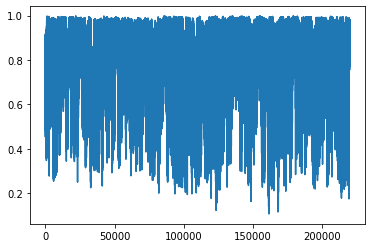

In [521]:
plt.plot(df_avl['xPass'])

In [522]:
tmp['xPass_avg'] = tmp['xPass'].expanding().mean() 
tmp = tmp[tmp['period']==1]

C:\Users\MatteoBENAUD\AppData\Local\Temp\ipykernel_1884\2641979309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['xPass_avg'] = tmp['xPass'].expanding().mean()


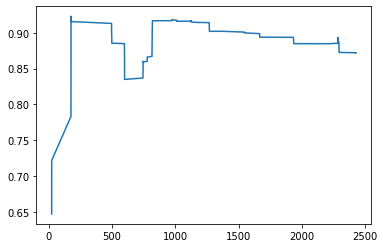

In [523]:
plt.plot(tmp['gameClock'],tmp['xPass_avg'])

In [577]:
tmp = df_avl.loc[df_avl['gameClock']==2154.60]

In [578]:
df_avl['coord_all_team'].iloc[0]

{14: [3.68, -30.25, 0.0],
 25: [8.52, -15.42, 0.0],
 9: [18.13, -29.64, 0.0],
 7: [18.34, -2.94, 0.0],
 10: [12.46, -26.26, 0.0],
 15: [-2.96, 6.39, 0.0],
 1: [-32.91, -3.6, 0.0],
 21: [27.89, -21.81, 0.0],
 33: [-5.59, -16.67, 0.0],
 5: [-3.27, 0.36, 0.0],
 11: [8.25, 7.64, 0.0]}

In [579]:
df_avl.iloc[180000:]

,period,gameClock,team.name,x_passer,y_passer,x_recipient,y_recipient,player.jersey_nb,pass.recipient.jersey_nb,coord_all_team,...,opponents_closer_to_goal_receiver,speed_receiver,bypassed_opponents,angle,opponents_in_path,nearest_defender_pass_line,distance_pass,xPass,player.id,pass.recipient.id
183990,2,2154.60,Manchester City WFC,6.62,-26.07,-43.53,-0.44,25,1,"{25: [6.62, -26.07, 0.0], 7: [6.01, -8.42, 0.0...",...,11,0.0,0,152.929933,2,1.576522,56.319796,0.902713,25632,4637
183991,2,2154.60,Manchester City WFC,6.62,-26.07,-11.46,5.06,25,12,"{25: [6.62, -26.07, 0.0], 7: [6.01, -8.42, 0.0...",...,7,0.0,0,120.147601,3,1.432526,35.999490,0.770352,25632,62666
183992,2,2154.60,Manchester City WFC,6.62,-26.07,-1.05,-16.55,25,21,"{25: [6.62, -26.07, 0.0], 7: [6.01, -8.42, 0.0...",...,4,0.0,0,128.857430,1,0.105404,12.225355,0.889021,25632,25554
183993,2,2154.60,Manchester City WFC,6.62,-26.07,-18.66,-7.14,25,33,"{25: [6.62, -26.07, 0.0], 7: [6.01, -8.42, 0.0...",...,10,0.0,0,143.173643,2,1.583930,31.582009,0.759735,25632,5078
183994,2,2154.60,Manchester City WFC,6.62,-26.07,-2.14,4.41,25,13,"{25: [6.62, -26.07, 0.0], 7: [6.01, -8.42, 0.0...",...,4,0.0,0,106.034734,1,0.661642,31.713846,0.800464,25632,6818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219613,2,2829.64,Manchester City WFC,51.00,33.62,43.61,-1.20,5,21,"{25: [19.0, 3.37, 0.0], 7: [35.31, 1.44, 0.0],...",...,8,0.0,0,-101.982335,5,0.642029,35.595569,0.785831,10252,25554
219614,2,2829.64,Manchester City WFC,51.00,33.62,45.68,-4.64,5,33,"{25: [19.0, 3.37, 0.0], 7: [35.31, 1.44, 0.0],...",...,7,0.0,0,-97.916141,6,0.392647,38.628099,0.829969,10252,5078
219615,2,2829.64,Manchester City WFC,51.00,33.62,37.86,22.62,5,13,"{25: [19.0, 3.37, 0.0], 7: [35.31, 1.44, 0.0],...",...,10,0.0,0,-140.066002,0,6.472104,17.136499,0.983278,10252,6818
219616,2,2829.64,Manchester City WFC,51.00,33.62,5.11,12.36,5,2,"{25: [19.0, 3.37, 0.0], 7: [35.31, 1.44, 0.0],...",...,11,0.0,0,-155.142571,1,0.838930,50.575485,0.906862,10252,221888


In [580]:
loc_adversary = tmp['coord_all_adversary'].iloc[0]
loc_team = tmp['coord_all_team'].iloc[0]

In [581]:
x_adversary = [value[0] for key, value in loc_adversary.items()]
y_adversary = [value[1] for key, value in loc_adversary.items()]
x_team = [value[0] for key, value in loc_team.items()]
y_team = [value[1] for key, value in loc_team.items()]

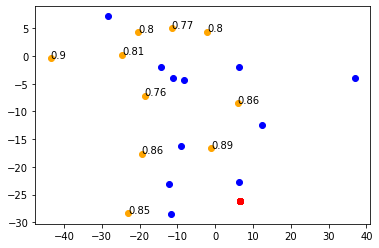

In [582]:
plt.scatter(tmp['x_passer'],tmp['y_passer'], c = 'r')
plt.scatter(tmp['x_recipient'],tmp['y_recipient'], c = 'orange')
for _,row in tmp.iterrows():
    plt.text(row['x_recipient'],row['y_recipient'],round(row['xPass'],2))
plt.scatter(x_adversary,y_adversary, c = 'b')
# plt.scatter(x_team,y_team, c = 'y')

In [588]:
df_avl_2 = df_avl[df_avl['period']==2]
df_avl_2 = df_avl_2[df_avl_2['gameClock']<=15*60]

### 

In [355]:
logisticRegr = LogisticRegression(max_iter = 1000)
logisticRegr.fit(X_train, y_train.values.ravel())
y_pred = logisticRegr.predict_proba(X_test)
roc_auc_score(y_test,y_pred[:,1])

0.7567672775182658

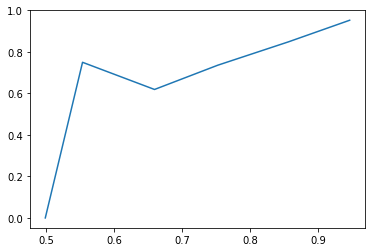

In [358]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
pos_frac, mean_val = calibration_curve(y_test,y_pred[:,1],n_bins=10)
plt.plot(mean_val, pos_frac)

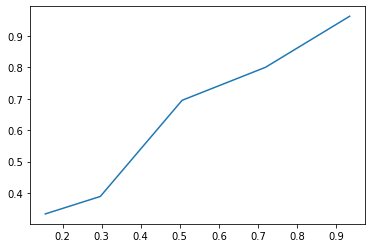

In [357]:
plt.plot(mean_val, pos_frac)